<a href="https://colab.research.google.com/github/LucArnal/SoundOfSalience/blob/master/DIN_French_Colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

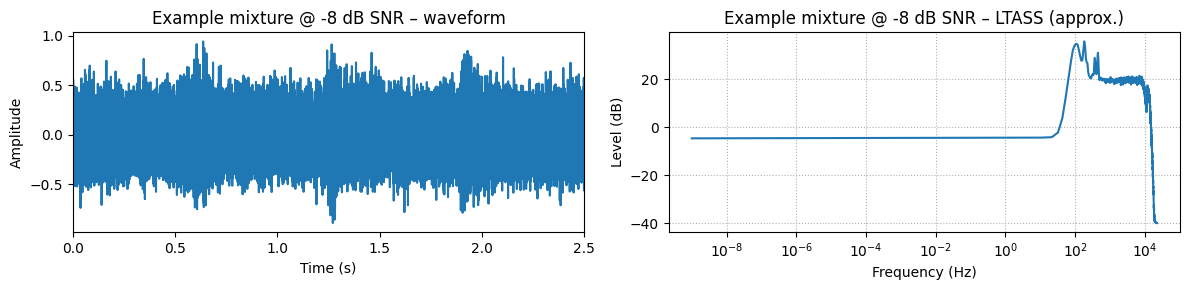

In [ ]:
# ============================================
# Colab DIN (French) – Aladdin-style Audio Prep with Visual Checks
# Source voice: Google Cloud TTS female fr-FR-Wavenet-D
# Files were manually edited in Audacity to isolate each digit (0–9).
#
# This notebook:
#  1) Loads 10 digit WAVs, bandlimits to [100, 9500] Hz
#  2) Designs an FIR EQ to match a target LTASS (flat 100–500 Hz, then −9 dB/octave to 9.5 kHz)
#  3) Applies EQ and RMS-normalizes the digits
#  4) Generates matched speech-shaped noise (same LTASS)
#  5) Builds 120 unique digit triplets with standardized timing
#  6) (Optional) Creates mixtures at a grid of SNRs and a CSV manifest for FADE/ASR
#
# Plots are provided after each major step to verify outcomes.
# ============================================

# ---- Install dependencies (Colab) ----
!pip -q install librosa==0.10.2.post1 soundfile==0.12.1 pandas==2.2.3 tqdm==4.66.5 matplotlib==3.9.2

import os, glob, math, random, itertools
import numpy as np
import pandas as pd
import soundfile as sf
import librosa
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy.signal import butter, lfilter, firwin2

# ---- Reproducibility ----
RNG_SEED = 42
random.seed(RNG_SEED)
np.random.seed(RNG_SEED)

# ---- Configuration ----
SR = 44100                 # target sample rate
BIT_DEPTH = 'PCM_16'       # saved WAV subtype
LP_HZ = 9500               # low-pass cutoff ~ 9.5 kHz (Aladdin convention)
HP_HZ = 100                # high-pass cutoff 100 Hz (Aladdin convention)
TARGET_RMS_dBFS = -23.0    # RMS normalization target
TRIPLET_PAD_PRE = 0.500    # seconds of silence before triplet
TRIPLET_PAD_POST = 0.500   # seconds of silence after triplet
GAP_BETWEEN_DIGITS = 0.200 # seconds between digits
NOISE_LEN_SEC = 120        # >= 60 s required for FADE; keep 120 s for safety

# SNR settings for optional mixtures:
SNRs_dB = [-12, -11, -10, -9, -8, -7, -6, -5, -4]  # typical DIN range around SRT
REPS_PER_SNR = 3            # per-triplet mixtures per SNR (reduce if too heavy)

# Paths
IN_DIR = 'input_digits'     # place your 10 digit WAVs here
EQ_DIR = 'out/digits_eq'
NOISE_DIR = 'out/noise'
TRIPLETS_DIR = 'out/triplets'
MIX_DIR = 'out/mixtures'
MANIFEST = 'out/manifest_fade.csv'
os.makedirs(EQ_DIR, exist_ok=True)
os.makedirs(NOISE_DIR, exist_ok=True)
os.makedirs(TRIPLETS_DIR, exist_ok=True)
os.makedirs(MIX_DIR, exist_ok=True)

# Map filenames (edit to match your actual file names)
digit_map = {
    0: "fr_digit_0.wav",
    1: "fr_digit_1.wav",
    2: "fr_digit_2.wav",
    3: "fr_digit_3.wav",
    4: "fr_digit_4.wav",
    5: "fr_digit_5.wav",
    6: "fr_digit_6.wav",
    7: "fr_digit_7.wav",
    8: "fr_digit_8.wav",
    9: "fr_digit_9.wav",
}

# ========== Helper functions ==========

def load_wav_mono(path, sr=SR):
    """Load WAV, convert to mono, resample to target SR."""
    x, srx = sf.read(path, always_2d=False)
    if x.ndim > 1:
        x = np.mean(x, axis=1)
    if srx != sr:
        x = librosa.resample(x, orig_sr=srx, target_sr=sr)
    return x

def butter_filter(x, sr, kind='low', fc=9500, order=6):
    """IIR Butterworth filter: kind in {'low','high'}."""
    nyq = 0.5*sr
    Wn = fc/nyq
    b, a = butter(order, Wn, btype=kind)
    return lfilter(b, a, x)

def bandlimit(x, sr=SR, hp=HP_HZ, lp=LP_HZ):
    """Apply 100 Hz high-pass and 9.5 kHz low-pass."""
    y = butter_filter(x, sr, 'high', hp)
    y = butter_filter(y, sr, 'low', lp)
    return y

def rms(x):
    return np.sqrt(np.mean(np.square(x), dtype=np.float64) + 1e-12)

def norm_rms(x, target_dbfs):
    """Normalize RMS to target dBFS with clipping safety."""
    peak = np.max(np.abs(x)) + 1e-12
    x = x / peak * 0.999  # pre-scale prevent clipping after gain
    cur_rms = rms(x)
    cur_dbfs = 20*np.log10(cur_rms + 1e-12)
    gain_db = target_dbfs - cur_dbfs
    g = 10**(gain_db/20)
    y = x * g
    y = np.clip(y, -0.999, 0.999)
    return y

def stft_mag_db(x, sr, n_fft=2048, hop=512):
    S = np.abs(librosa.stft(x, n_fft=n_fft, hop_length=hop, window='hann'))
    S_db = librosa.amplitude_to_db(S + 1e-12, ref=np.max)
    freqs = librosa.fft_frequencies(sr=sr, n_fft=n_fft)
    times = librosa.frames_to_time(np.arange(S.shape[1]), sr=sr, hop_length=hop)
    return freqs, times, S_db

def welch_psd(x, sr, n_fft=4096, hop=2048):
    """Simple average of STFT mag^2 over time as proxy for LTASS curve."""
    S = np.abs(librosa.stft(x, n_fft=n_fft, hop_length=hop, window='hann'))**2
    f = np.linspace(0, sr/2, S.shape[0])
    psd = np.mean(S[:len(f), :], axis=1)
    return f, psd + 1e-12

def plot_wave_and_spectrum(x, sr, title="Signal", xlim_s=None):
    """Waveform + approximate LTASS curve."""
    fig, axes = plt.subplots(1, 2, figsize=(12,3))
    t = np.arange(len(x))/sr
    axes[0].plot(t, x)
    axes[0].set_title(f"{title} – waveform")
    axes[0].set_xlabel("Time (s)")
    axes[0].set_ylabel("Amplitude")
    if xlim_s:
        axes[0].set_xlim(0, xlim_s)

    f, psd = welch_psd(x, sr)
    axes[1].semilogx(f+1e-9, 10*np.log10(psd))
    axes[1].set_title(f"{title} – LTASS (approx.)")
    axes[1].set_xlabel("Frequency (Hz)")
    axes[1].set_ylabel("Level (dB)")
    axes[1].grid(True, which='both', ls=':')
    plt.tight_layout()
    plt.show()

# Target LTASS function (SII-like):
def target_ltass_sii(f):
    """
    Amplitude target:
    - flat between 100–500 Hz,
    - then −9 dB/octave roll-off up to 9.5 kHz (implemented as amplitude factor).
    Below 100 Hz: gently fade.
    """
    eps = 1e-9
    amp = np.zeros_like(f, dtype=float)
    ref = 1.0
    for i, fi in enumerate(f):
        if fi < 100:
            amp[i] = ref * (fi/100.0 + eps)  # gentle fade-in
        elif fi <= 500:
            amp[i] = ref
        else:
            octs = np.log2((fi+eps)/500.0)
            amp[i] = ref * (10**((-9/20.0)*octs))
    return amp + 1e-12

def design_eq_filter_from_avg(digit_signals, sr=SR, n_taps=1025):
    """
    Compute an FIR EQ so that the *average* digit LTASS matches target_ltass_sii.
    Limits per-bin correction to ±12 dB for stability.
    """
    concat = np.concatenate([x for x in digit_signals])
    f, psd = welch_psd(concat, sr)
    mag = np.sqrt(psd)
    tgt = target_ltass_sii(f)

    corr = np.clip(tgt / (mag + 1e-12), 0.25, 4.0)   # amplitude ratio clip
    corr /= np.max(corr)                             # normalize max to 1

    freqs = f / (sr/2)
    gains = corr.copy()
    # stabilize endpoints
    freqs[0] = 0.0; freqs[-1] = 1.0
    gains[0] = gains[1]; gains[-1] = gains[-2]

    taps = firwin2(n_taps, freqs, gains, window='hann')
    return taps, f, mag, tgt

def apply_fir(x, taps):
    return np.convolve(x, taps, mode='same')

def mix_at_snr(clean, noise, snr_db):
    """
    Create a mixture at a target SNR (in dB) by scaling noise RMS relative to clean RMS.
    Picks a random noise segment of clean length.
    """
    if len(noise) < len(clean) + SR:
        reps = int(np.ceil((len(clean)+SR)/len(noise)))
        noise = np.tile(noise, reps)
    start = np.random.randint(0, len(noise)-len(clean))
    nseg = noise[start:start+len(clean)].copy()

    r_c = rms(clean)
    r_n = rms(nseg)
    target_rn = r_c / (10**(snr_db/20.0))
    nseg *= (target_rn / (r_n + 1e-12))
    mix = clean + nseg
    peak = np.max(np.abs(mix))+1e-12
    if peak > 0.999:
        mix = mix / peak * 0.999
    return mix

# ========== 1) Load digits and bandlimit ==========
print("Loading and bandlimiting digits...")
digits_raw = {}
for d, fname in digit_map.items():
    path = os.path.join(IN_DIR, fname)
    if not os.path.exists(path):
        raise FileNotFoundError(f"Missing digit file: {path}")
    x = load_wav_mono(path, sr=SR)
    x = bandlimit(x, SR, HP_HZ, LP_HZ)
    digits_raw[d] = x

# Visual check: one example digit before EQ
example_d = 7
plot_wave_and_spectrum(digits_raw[example_d], SR, title=f"Digit {example_d} (bandlimited)")

# ========== 2) Design LTASS EQ and apply to digits ==========
print("Designing LTASS-matching FIR EQ...")
eq_taps, f_ref, mag_ref, tgt_ref = design_eq_filter_from_avg(list(digits_raw.values()), sr=SR, n_taps=1025)

# Visualize target vs. average magnitude before EQ
plt.figure(figsize=(6,3))
plt.semilogx(f_ref+1e-9, 20*np.log10(mag_ref), label="Average digit mag (pre-EQ)")
plt.semilogx(f_ref+1e-9, 20*np.log10(tgt_ref), label="Target LTASS (SII-like)")
plt.xlabel("Frequency (Hz)"); plt.ylabel("Level (dB)")
plt.title("Average digit LTASS vs. target (before EQ)")
plt.grid(True, which='both', ls=':')
plt.legend(); plt.tight_layout(); plt.show()

# Apply EQ and RMS normalize
digits_eq = {}
for d, x in digits_raw.items():
    y = apply_fir(x, eq_taps)
    y = norm_rms(y, TARGET_RMS_dBFS)
    outp = os.path.join(EQ_DIR, f"digit_{d}.wav")
    sf.write(outp, y, SR, subtype=BIT_DEPTH)
    digits_eq[d] = y

# Visual check: example digit after EQ
plot_wave_and_spectrum(digits_eq[example_d], SR, title=f"Digit {example_d} (EQ+RMS)")

# ========== 3) Generate matched speech-shaped noise ==========
print("Generating speech-shaped noise...")
white = np.random.randn(NOISE_LEN_SEC*SR).astype(np.float32)
white = bandlimit(white, SR, HP_HZ, LP_HZ)
noise_shaped = apply_fir(white, eq_taps)
noise_shaped = norm_rms(noise_shaped, TARGET_RMS_dBFS - 3.0)  # slight offset if desired
noise_path = os.path.join(NOISE_DIR, "ssn.wav")
sf.write(noise_path, noise_shaped, SR, subtype=BIT_DEPTH)

# Visual check: noise LTASS
plot_wave_and_spectrum(noise_shaped, SR, title="Speech-shaped noise")

# ========== 4) Build 120 triplets with standardized timing ==========
print("Building 120 unique triplets...")
triplets = []
for comb in itertools.permutations(range(10), 3):
    triplets.append(comb)
random.shuffle(triplets)
triplets = triplets[:120]

sil_gap = np.zeros(int(GAP_BETWEEN_DIGITS*SR))
pad_pre = np.zeros(int(TRIPLET_PAD_PRE*SR))
pad_post = np.zeros(int(TRIPLET_PAD_POST*SR))

triplet_paths = []
for i, (a,b,c) in enumerate(triplets, start=1):
    wav = np.concatenate([
        pad_pre,
        digits_eq[a], sil_gap,
        digits_eq[b], sil_gap,
        digits_eq[c],
        pad_post
    ])
    wav = norm_rms(wav, TARGET_RMS_dBFS)
    name = f"triplet_{i:03d}_{a}{b}{c}.wav"
    p = os.path.join(TRIPLETS_DIR, name)
    sf.write(p, wav, SR, subtype=BIT_DEPTH)
    triplet_paths.append((p, f"{a}{b}{c}"))

# Visual check: one example triplet (waveform + spectrogram)
ex_trip_path, ex_label = triplet_paths[0]
ex_trip, _ = sf.read(ex_trip_path)
plot_wave_and_spectrum(ex_trip, SR, title=f"Example triplet {ex_label}", xlim_s=2.5)

# Spectrogram view
f_spec, t_spec, S_db = stft_mag_db(ex_trip, SR, n_fft=2048, hop=256)
plt.figure(figsize=(8,3))
plt.pcolormesh(t_spec, f_spec, S_db, shading='auto')
plt.yscale('log'); plt.ylim(100, 10000)
plt.xlabel("Time (s)"); plt.ylabel("Frequency (Hz)")
plt.title(f"Spectrogram – triplet {ex_label}")
plt.colorbar(label="dB")
plt.tight_layout(); plt.show()

# ========== 5) (Optional) Create mixtures across SNRs + manifest ==========
print("Creating optional mixtures and manifest for FADE/ASR...")
rows = []
for p, label in tqdm(triplet_paths, total=len(triplet_paths)):
    clean, sr_read = sf.read(p)
    assert sr_read == SR
    for snr in SNRs_dB:
        for r in range(REPS_PER_SNR):
            out_name = f"mix_{os.path.basename(p).replace('.wav','')}_SNR{snr}_{r}.wav"
            out_path = os.path.join(MIX_DIR, out_name)
            mix = mix_at_snr(clean, noise_shaped, snr)
            sf.write(out_path, mix, SR, subtype=BIT_DEPTH)
            rows.append({
                "wav": out_path,
                "label": label,  # e.g., "274"
                "snr_db": snr,
                "type": "triplet"
            })

pd.DataFrame(rows).to_csv(MANIFEST, index=False)
print(f"Done. All outputs in: {os.path.abspath('out/')}")

# Visual check: one mixture at -8 dB SNR
ex_mix = mix_at_snr(ex_trip, noise_shaped, -8)
plot_wave_and_spectrum(ex_mix, SR, title="Example mixture @ -8 dB SNR", xlim_s=2.5)


In [ ]:
!zip -r out_all.zip out/
from google.colab import files
files.download("out_all.zip")

  adding: out/ (stored 0%)
  adding: out/digits_eq/ (stored 0%)
  adding: out/digits_eq/digit_8.wav (deflated 22%)
  adding: out/digits_eq/digit_9.wav (deflated 18%)
  adding: out/digits_eq/digit_5.wav (deflated 17%)
  adding: out/digits_eq/digit_4.wav (deflated 20%)
  adding: out/digits_eq/digit_2.wav (deflated 14%)
  adding: out/digits_eq/digit_0.wav (deflated 13%)
  adding: out/digits_eq/digit_1.wav (deflated 20%)
  adding: out/digits_eq/digit_3.wav (deflated 17%)
  adding: out/digits_eq/digit_7.wav (deflated 25%)
  adding: out/digits_eq/digit_6.wav (deflated 12%)
  adding: out/triplets/ (stored 0%)
  adding: out/triplets/triplet_046_264.wav (deflated 60%)
  adding: out/triplets/triplet_095_024.wav (deflated 62%)
  adding: out/triplets/triplet_037_256.wav (deflated 58%)
  adding: out/triplets/triplet_085_408.wav (deflated 61%)
  adding: out/triplets/triplet_103_825.wav (deflated 60%)
  adding: out/triplets/triplet_010_459.wav (deflated 59%)
  adding: out/triplets/triplet_017_645.wav

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>